# Part 1: Pong Tournament
## **DQN and REINFORCE implementation on Pong environment**

In [2]:
!pip install gymnasium[atari]
!pip install gymnasium[accept-rom-license]
!pip install ale-py
!pip install autorom
!AutoROM --accept-license

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 27.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: shimmy
    Found existing installation: Shimmy 1.3.0
    Uninstalling Shimmy-1.3.0:
      Successfully uninstalled Shimmy-1.3.0
  Attempting uninstall: ale-py
    Found existing installation: ale-py 0.11.2
    Uninstalling ale-py-0.11.2:
      Successfully uninstalled ale-py-0.11.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kaggle-environments 1.18.0 requires shimmy>=1.2.1, but you have shimmy 0.2.1 which is incompatible.
dopamine-rl 4.1.2 requires ale-py>=0.10.1, but you have ale-py 0.8.1 which is incompatible.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.7/434.7 kB 11.5 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requi

Import necessary libraries

In [3]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import collections
import random
import time
import datetime
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
print(f"Using Gymnasium version: {gym.__version__}")
print(f"Using PyTorch version: {torch.__version__}")

# Define the Experience tuple
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'new_state', 'done'])

Using device: cuda
Using Gymnasium version: 0.29.0
Using PyTorch version: 2.6.0+cu124


## Data preprocessing (Wrappers)
We need to apply the same set of wrappers used during the model's training phase to ensure that the inputs to the model are consistent in shape, format, and meaning.

In [5]:
# Fixed Environment Wrappers for Gymnasium
class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        # Fire action to start the game
        action_meanings = env.unwrapped.get_action_meanings()
        if len(action_meanings) > 1:
            self._has_fire_action = action_meanings[1] == 'FIRE'
        else:
            self._has_fire_action = False

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        if self._has_fire_action: # in case the env needs a FIRE at beginning
            obs, _, terminated, truncated, _ = self.env.step(1)
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
            obs, _, terminated, truncated, _ = self.env.step(2) # second action
            if terminated or truncated:
                obs, info = self.env.reset(**kwargs)
        return obs, info

    def step(self, action):
        return self.env.step(action)

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        super().__init__(env)
        # buffer to store the last two observations
        self._obs_buffer = collections.deque(maxlen=2)
        # #skipframes
        self._skip = skip

    def step(self, action):
        total_reward = 0.0
        terminated = False
        truncated = False
        info = {}
        
        for _ in range(self._skip): # repeat same action for some frames
            obs, reward, terminated, truncated, info = self.env.step(action)
            self._obs_buffer.append(obs)
            total_reward += reward
            if terminated or truncated:
                break
        # take max over last two frames
        max_frame = np.max(np.stack(self._obs_buffer), axis=0)
        return max_frame, total_reward, terminated, truncated, info

    def reset(self, **kwargs):
        self._obs_buffer.clear()
        obs, info = self.env.reset(**kwargs)
        self._obs_buffer.append(obs)
        return obs, info

class ProcessFrame84(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env) # output os: 84x84 grayscale
        self.observation_space = gym.spaces.Box(low=0, high=255, shape=(84, 84, 1), dtype=np.uint8)

    def observation(self, obs):
        return self._process_frame(obs)

    def _process_frame(self, frame):
        if frame.size == 210 * 160 * 3:
            img = np.reshape(frame, [210, 160, 3]).astype(np.float32)
        elif frame.size == 250 * 160 * 3:
            img = np.reshape(frame, [250, 160, 3]).astype(np.float32)
        else:
            # try to handle different frame sizes
            img = frame.astype(np.float32)
            if len(img.shape) == 3 and img.shape[2] == 3:
                pass  # Already in correct format
            else:
                # Assume standard Atari frame shape
                try:
                    img = img.reshape((210, 160, 3))
                except:
                    # If reshaping fails, use as is and hope for the best
                    pass
        
        # Convert to grayscale
        img = img[:, :, 0] * 0.299 + img[:, :, 1] * 0.587 + img[:, :, 2] * 0.114
        
        # Resize
        resized_screen = cv2.resize(img, (84, 110), interpolation=cv2.INTER_AREA)
        x_t = resized_screen[18:102, :]
        x_t = np.reshape(x_t, [84, 84, 1])
        return x_t.astype(np.uint8)

class BufferWrapper(gym.ObservationWrapper):
    def __init__(self, env, n_steps):
        super().__init__(env)
        self.n_steps = n_steps
        old_space = env.observation_space
        
        # Fix: Properly handle the observation space dimensions
        new_shape = (old_space.shape[0], old_space.shape[1], old_space.shape[2] * n_steps)

        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0,
            shape=new_shape,
            dtype=np.float32
        )

        self.buffer = deque(maxlen=n_steps)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        for _ in range(self.n_steps):
            self.buffer.append(obs)
        return self._get_obs(), info

    def observation(self, obs):
        self.buffer.append(obs)
        return self._get_obs()

    def _get_obs(self):
        # Stack along channel axis (axis=2 for HWC format)
        return np.concatenate(list(self.buffer), axis=2) 

class ImageToPyTorch(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        old_shape = self.observation_space.shape
        # Fix: Change from HWC to CHW format
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=(old_shape[2], old_shape[0], old_shape[1]), dtype=np.float32
        )

    def observation(self, obs):
        # Fix: Properly transpose from HWC to CHW
        return np.transpose(obs, (2, 0, 1))

class ScaledFloatFrame(gym.ObservationWrapper):
    def observation(self, obs):
        return np.array(obs, dtype=np.float32) / 255.0


# Create environment function
def make_env(env_name):
    env = gym.make(env_name, render_mode='rgb_array')
    env = MaxAndSkipEnv(env)
    env = FireResetEnv(env)
    env = ProcessFrame84(env)
    env = ImageToPyTorch(env)
    env = BufferWrapper(env, 4)
    env = ScaledFloatFrame(env)
    return env

## Test the environment wrappers

In [6]:
ENV_NAME = "PongNoFrameskip-v4"
test_env = make_env(ENV_NAME)

# Print environment info
print("*** Test Environment ***")
print(f"Observation space shape: {test_env.observation_space.shape}")
print(f"Observation space type: {test_env.observation_space.dtype}")
print(f"Action space: {test_env.action_space}")
print(f"Number of actions: {test_env.action_space.n}")

# Test reset
obs, info = test_env.reset()
print(f"\nInitial observation shape: {obs.shape}")
print(f"Initial observation range: [{obs.min()}, {obs.max()}]")

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]


*** Test Environment ***
Observation space shape: (1, 84, 336)
Observation space type: float32
Action space: Discrete(6)
Number of actions: 6

Initial observation shape: (1, 84, 336)
Initial observation range: [0.34117648005485535, 0.6352941393852234]


# **DQN**

In [7]:
# DQN Network
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        # Calculate the size of the flattened features
        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.conv(dummy_input)
            n_flatten = conv_out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions)
        )

    def forward(self, x):
        # x shape: [batch_size, channels, height, width]
        conv_out = self.conv(x)
        flattened = conv_out.view(conv_out.size(0), -1)
        return self.fc(flattened)

# Test the network
test_net = DQN(test_env.observation_space.shape, test_env.action_space.n).to(device)
print(f"Network architecture: {test_net}")
print(f"Number of parameters: {sum(p.numel() for p in test_net.parameters())}")

Network architecture: DQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=17024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Number of parameters: 8791718


In [8]:
# Experience Buffer
class ExperienceBuffer:
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, experience):
        self.buffer.append(experience)

    def sample(self, batch_size):
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, next_states, dones = zip(*[self.buffer[i] for i in indices])

        return (
            np.array(states, dtype=np.float32),
            np.array(actions, dtype=np.int64),
            np.array(rewards, dtype=np.float32),
            np.array(next_states, dtype=np.float32),
            np.array(dones, dtype=np.bool_)
        )

# Agent
class Agent:
    def __init__(self, env, exp_buffer):
        self.env = env
        self.exp_buffer = exp_buffer
        self.reset()

    def reset(self):
        self.state, _ = self.env.reset()
        self.total_reward = 0.0

    @torch.no_grad()
    def play_step(self, net, epsilon, device="cpu"):
        done_reward = None
    
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state_v = torch.tensor(np.array([self.state], copy=False), dtype=torch.float32).to(device)
            q_vals = net(state_v)
            _, act_v = torch.max(q_vals, dim=1)
            action = int(act_v.item())
    
        new_state, reward, terminated, truncated, _ = self.env.step(action)
        done = terminated or truncated
    
        exp = Experience(self.state, action, reward, new_state, done)
        self.exp_buffer.append(exp)
    
        self.state = new_state
        self.total_reward += reward
    
        if done:
            done_reward = self.total_reward
            self.reset()
    
        return done_reward

In [9]:
# Loss calculation functions
def calc_loss(batch, net, tgt_net, device, gamma):
    states, actions, rewards, next_states, dones = batch

    states_v = torch.tensor(states, dtype=torch.float32).to(device)
    next_states_v = torch.tensor(next_states, dtype=torch.float32).to(device)
    actions_v = torch.tensor(actions, dtype=torch.int64).to(device)
    rewards_v = torch.tensor(rewards, dtype=torch.float32).to(device)
    done_mask = torch.tensor(dones, dtype=torch.bool).to(device)

    state_action_values = net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)

    with torch.no_grad():
        next_state_values = tgt_net(next_states_v).max(1)[0]
        next_state_values[done_mask] = 0.0
        expected_state_action_values = rewards_v + gamma * next_state_values

    return nn.MSELoss()(state_action_values, expected_state_action_values)

# Plotting function
def plot_rewards(rewards, ma_window=100):
    plt.figure(figsize=(12, 8))
    plt.title("Training Rewards")
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    
    if len(rewards) > 0:
        plt.plot(rewards, alpha=0.3, label='Raw rewards', color='blue')
        
        if len(rewards) >= ma_window:
            ma_rewards = []
            for i in range(len(rewards) - ma_window + 1):
                ma_rewards.append(np.mean(rewards[i:i+ma_window]))
            plt.plot(range(ma_window-1, len(rewards)), ma_rewards, 
                    label=f'Moving Average ({ma_window} episodes)', color='red', linewidth=2)
        
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

## Training

In [10]:
def train_dqn():
    # Create models directory
    os.makedirs("models", exist_ok=True)
    
    # Parameters
    ENV_NAME = "PongNoFrameskip-v4"
    MEAN_REWARD_BOUND = 18.0  # solved when average reward > 18
    
    GAMMA = 0.99
    BATCH_SIZE = 32
    REPLAY_SIZE = 10000
    LEARNING_RATE = 1e-4
    SYNC_TARGET_FRAMES = 1000  # Reduced for faster updates
    REPLAY_START_SIZE = 10000  # Increased for more initial experiences
    
    EPSILON_DECAY_LAST_FRAME = 100000
    EPSILON_START = 1.0
    EPSILON_FINAL = 0.02
    
    print(f"Training DQN on {ENV_NAME}")
    print(f"Device: {device}")
    
    # Create environment
    env = make_env(ENV_NAME)

    # Initialize networks
    net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net = DQN(env.observation_space.shape, env.action_space.n).to(device)
    tgt_net.load_state_dict(net.state_dict())
    
    print(f"Network: {net}")
    print(f"Input shape: {env.observation_space.shape}")
    print(f"Number of actions: {env.action_space.n}")
    
    # Initialize buffer and agent
    buffer = ExperienceBuffer(REPLAY_SIZE)
    agent = Agent(env, buffer)
    
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    total_rewards = []
    frame_idx = 0
    ts_frame = 0
    ts = time.time()
    best_mean_reward = None
    
    print("Filling replay buffer...")
    while len(buffer) < REPLAY_START_SIZE:
        frame_idx += 1
        epsilon = 1.0  # Always explore during initial filling
        reward = agent.play_step(net, epsilon, device)
        if reward is not None:
            total_rewards.append(reward)
            
        if frame_idx % 1000 == 0:
            print(f"Filled {len(buffer)}/{REPLAY_START_SIZE} experiences in replay buffer")
    
    print("Replay buffer filled. Starting training...")
    
    episode_count = 0
    
    max_frames = 450000
    
    while frame_idx < max_frames:
        frame_idx += 1
        
        # Calculate epsilon
        epsilon = max(EPSILON_FINAL, 
                     EPSILON_START - (EPSILON_START - EPSILON_FINAL) * frame_idx / EPSILON_DECAY_LAST_FRAME)
        
        reward = agent.play_step(net, epsilon, device)
        if reward is not None:
            total_rewards.append(reward)
            episode_count += 1
            
            # Calculate mean reward over last 100 episodes
            mean_reward = np.mean(total_rewards[-100:]) if len(total_rewards) >= 100 else np.mean(total_rewards)
            
            # Calculate speed
            speed = (frame_idx - ts_frame) / (time.time() - ts)
            ts_frame = frame_idx
            ts = time.time()
            
            # Print progress every 10 episodes
            if episode_count % 10 == 0:
                print(f"Episode {episode_count}, Frame {frame_idx}, Reward: {reward:.1f}, "
                      f"Mean Reward (last 100): {mean_reward:.3f}, Epsilon: {epsilon:.3f}, Speed: {speed:.2f} f/s")
            
            # Save best model
            if best_mean_reward is None or mean_reward > best_mean_reward:
                if best_mean_reward is not None:
                    print(f"New best mean reward: {best_mean_reward:.3f} -> {mean_reward:.3f}")
                best_mean_reward = mean_reward
                model_path = f"models/dqn_best.pth"
                torch.save(net.state_dict(), model_path)
            
            # Check if solved
            if mean_reward >= MEAN_REWARD_BOUND:
                print(f"Solved at frame {frame_idx} with mean reward {mean_reward:.3f}!")
                break
        
        # Sync target network
        if frame_idx % SYNC_TARGET_FRAMES == 0:
            tgt_net.load_state_dict(net.state_dict())
            print(f"Target network updated at frame {frame_idx}")
        
        # Training step - only train if we have enough samples
        if len(buffer) >= BATCH_SIZE:
            optimizer.zero_grad()
            batch = buffer.sample(BATCH_SIZE)
            loss_t = calc_loss(batch, net, tgt_net, device, GAMMA)
            loss_t.backward()
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
            optimizer.step()
            
    print("Training completed at:", datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
    print(f"Trained for {frame_idx} frames, {episode_count} episodes")
    
    # Save final model
    final_model_path = f"models/dqn_best.pth"
    torch.save(net.state_dict(), final_model_path)
    print(f"Final model saved to {final_model_path}")
    
    return total_rewards, net

In [11]:
print("STARTING DQN TRAINING ON PONG")
rewards, trained_net = train_dqn()

STARTING DQN TRAINING ON PONG
Training DQN on PongNoFrameskip-v4
Device: cuda
Network: DQN(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=17024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
Input shape: (1, 84, 336)
Number of actions: 6
Filling replay buffer...
Filled 1000/10000 experiences in replay buffer
Filled 2000/10000 experiences in replay buffer
Filled 3000/10000 experiences in replay buffer
Filled 4000/10000 experiences in replay buffer
Filled 5000/10000 experiences in replay buffer
Filled 6000/10000 experiences in replay buffer
Filled 7000/10000 experiences in replay buffer
Filled 8000/10000 experiences in replay buffer
Filled 9000/10000 experiences in replay buff

## Final Plot

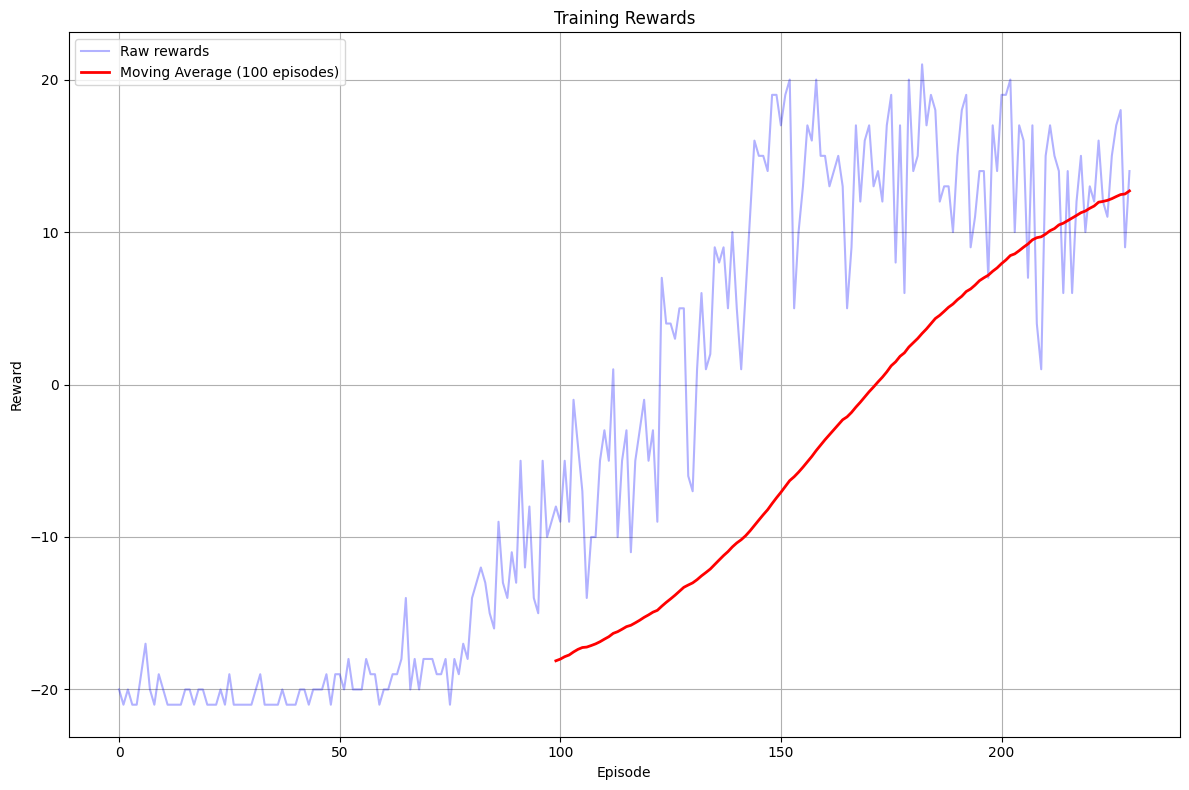

Total episodes trained: 230
Best reward achieved: 21.0
Mean reward of last 100 episodes: 12.7


In [12]:
# Plot final results
if rewards:
    plot_rewards(rewards, ma_window=100)
    print(f"Total episodes trained: {len(rewards)}")
    print(f"Best reward achieved: {max(rewards) if rewards else 0}")
    print(f"Mean reward of last 100 episodes: {np.mean(rewards[-100:]) if len(rewards) >= 100 else np.mean(rewards)}")

# **REINFORCE**
For REINFORCE, we need a policy network that outputs action probabilities.

In [13]:
import torch.distributions as distributions

ENV_NAME = "PongNoFrameskip-v4"
env = make_env(ENV_NAME)

print("*** Pong Environment for REINFORCE ***")
print(f"Observation space shape: {env.observation_space.shape}")
print(f"Number of actions: {env.action_space.n}")
print(f"Observation range: [{env.observation_space.low.min():.3f}, {env.observation_space.high.max():.3f}]")

*** Pong Environment for REINFORCE ***
Observation space shape: (1, 84, 336)
Number of actions: 6
Observation range: [0.000, 1.000]


In [14]:
class PolicyNetwork(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(PolicyNetwork, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU(),
        )

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_shape)
            conv_out = self.conv(dummy_input)
            n_flatten = conv_out.view(1, -1).size(1)

        self.fc = nn.Sequential(
            nn.Linear(n_flatten, 512),
            nn.ReLU(),
            nn.Linear(512, n_actions),
            nn.Softmax(dim=-1) # Output a probability distribution
        )

    def forward(self, x):
        conv_out = self.conv(x)
        flattened = conv_out.view(conv_out.size(0), -1)
        return self.fc(flattened)

# Create policy network
input_shape = env.observation_space.shape
n_actions = env.action_space.n
policy = PolicyNetwork(input_shape, n_actions).to(device)

optimizer = optim.Adam(policy.parameters(), lr=1e-4)
gamma = 0.99

print("Policy Network:")
print(policy)
print(f"Number of parameters: {sum(p.numel() for p in policy.parameters()):,}")

Policy Network:
PolicyNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=17024, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
    (3): Softmax(dim=-1)
  )
)
Number of parameters: 8,791,718


In [15]:
def calc_discounted_returns(rewards, gamma):
    returns = []
    R = 0
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    
    returns = torch.tensor(returns, dtype=torch.float32)
    # Standardize returns for stability
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns

## Training

In [16]:
def train_reinforce():
    os.makedirs("models_reinforce", exist_ok=True)
    
    # Hyperparameters
    GAMMA = 0.99
    LEARNING_RATE = 5e-4 # Policy gradients often need a smaller LR
    MAX_EPISODES = 1000
    ENV_NAME = "PongNoFrameskip-v4"
    
    env = make_env(ENV_NAME)
    net = PolicyNetwork(env.observation_space.shape, env.action_space.n).to(device)
    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)
    
    total_rewards = []
    
    print(f"Starting REINFORCE training on {ENV_NAME}...")
    
    for episode in range(MAX_EPISODES):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        # 1. Collect one episode
        while not done:
            state_v = torch.tensor(np.array([state], copy=False), dtype=torch.float32).to(device)
            probs = net(state_v)
            
            # Sample action from the probability distribution
            action_dist = torch.distributions.Categorical(probs)
            action = action_dist.sample()
            
            log_prob = action_dist.log_prob(action)
            new_state, reward, terminated, truncated, _ = env.step(action.item())
            
            log_probs.append(log_prob)
            rewards.append(reward)
            state = new_state
            done = terminated or truncated
            
        episode_reward = sum(rewards)
        total_rewards.append(episode_reward)
        
        # 2. Calculate Loss and Update
        returns = calc_discounted_returns(rewards, GAMMA).to(device)
        
        policy_loss = []
        for log_prob, Gt in zip(log_probs, returns):
            # Loss = -log_prob * Return
            policy_loss.append(-log_prob * Gt)
            
        optimizer.zero_grad()
        policy_loss = torch.stack(policy_loss).sum()
        policy_loss.backward()
        optimizer.step()
        
        # Logging
        if episode % 10 == 0:
            mean_reward = np.mean(total_rewards[-100:])
            print(f"Episode {episode}, Reward: {episode_reward:.1f}, Mean Reward (100): {mean_reward:.2f}")

        # Save model if it's the best so far
        if episode_reward >= max(total_rewards, default=-21):
            torch.save(net.state_dict(), f"models_reinforce/reinforce_best.pth")

    return total_rewards

reinforce_rewards = train_reinforce()

Starting REINFORCE training on PongNoFrameskip-v4...
Episode 0, Reward: -19.0, Mean Reward (100): -19.00
Episode 10, Reward: -21.0, Mean Reward (100): -20.45
Episode 20, Reward: -21.0, Mean Reward (100): -20.52
Episode 30, Reward: -20.0, Mean Reward (100): -20.39
Episode 40, Reward: -19.0, Mean Reward (100): -20.24
Episode 50, Reward: -21.0, Mean Reward (100): -20.25
Episode 60, Reward: -21.0, Mean Reward (100): -20.26
Episode 70, Reward: -21.0, Mean Reward (100): -20.17
Episode 80, Reward: -18.0, Mean Reward (100): -20.19
Episode 90, Reward: -21.0, Mean Reward (100): -20.18
Episode 100, Reward: -21.0, Mean Reward (100): -20.25
Episode 110, Reward: -21.0, Mean Reward (100): -20.20
Episode 120, Reward: -20.0, Mean Reward (100): -20.17
Episode 130, Reward: -21.0, Mean Reward (100): -20.16
Episode 140, Reward: -21.0, Mean Reward (100): -20.26
Episode 150, Reward: -21.0, Mean Reward (100): -20.28
Episode 160, Reward: -21.0, Mean Reward (100): -20.25
Episode 170, Reward: -21.0, Mean Reward 

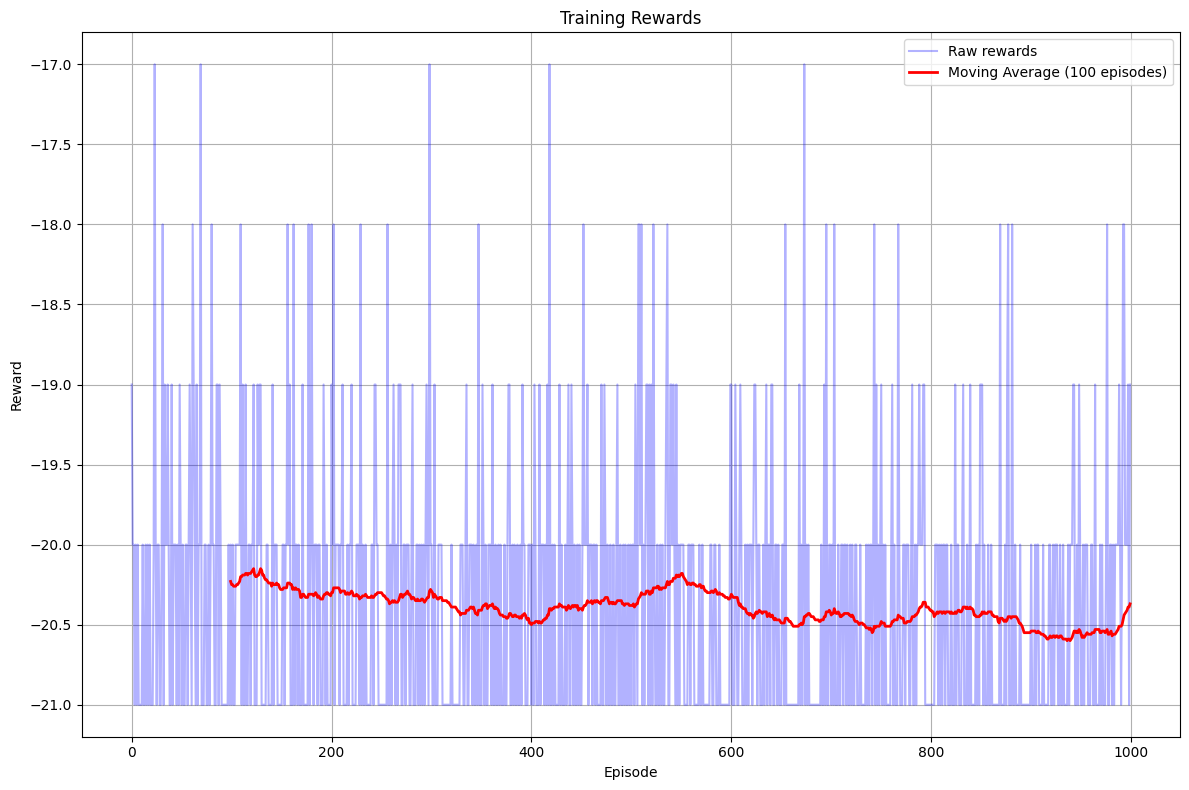

Total episodes trained: 1000
Best reward achieved: -17.0
Mean reward of last 100 episodes: -20.37


In [17]:
if reinforce_rewards:
    plot_rewards(reinforce_rewards, ma_window=100)
    print(f"Total episodes trained: {len(reinforce_rewards)}")
    print(f"Best reward achieved: {max(reinforce_rewards)}")
    print(
        f"Mean reward of last 100 episodes: "
        f"{np.mean(reinforce_rewards[-100:]) if len(reinforce_rewards) >= 100 else np.mean(reinforce_rewards)}"
    )


# Evaluation


Successfully loaded best DQN model from models/dqn_best.pth
Successfully loaded best REINFORCE model from models_reinforce/reinforce_best.pth
Evaluating DQN Agent
Starting evaluation over 50 episodes...
Episode 1/50 completed with reward: 20.0
Episode 2/50 completed with reward: 20.0
Episode 3/50 completed with reward: 20.0
Episode 4/50 completed with reward: 20.0
Episode 5/50 completed with reward: 20.0
Episode 6/50 completed with reward: 20.0
Episode 7/50 completed with reward: 20.0
Episode 8/50 completed with reward: 20.0
Episode 9/50 completed with reward: 20.0
Episode 10/50 completed with reward: 20.0
Episode 11/50 completed with reward: 20.0
Episode 12/50 completed with reward: 20.0
Episode 13/50 completed with reward: 20.0
Episode 14/50 completed with reward: 20.0
Episode 15/50 completed with reward: 20.0
Episode 16/50 completed with reward: 20.0
Episode 17/50 completed with reward: 20.0
Episode 18/50 completed with reward: 20.0
Episode 19/50 completed with reward: 20.0
Episode

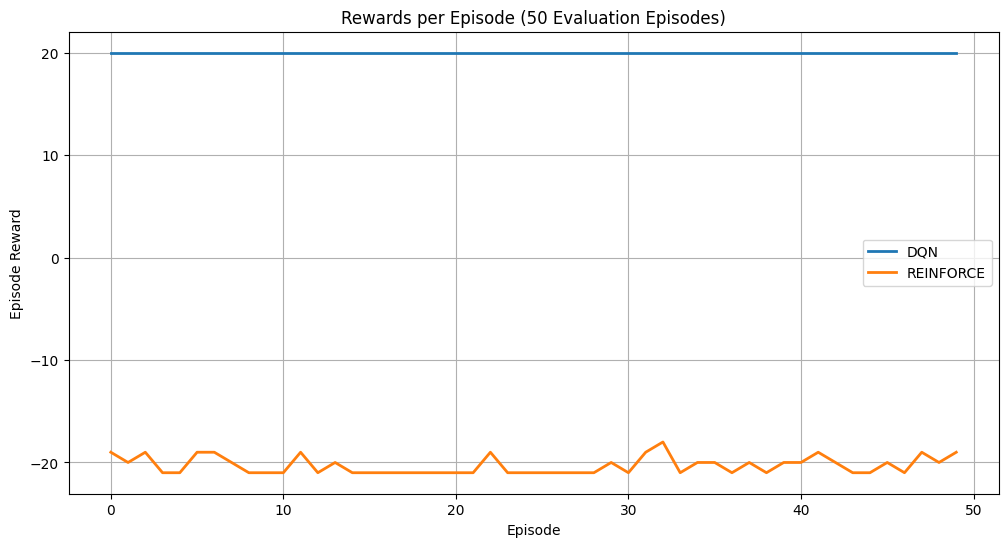

In [18]:
# Helper function to evaluate an agent's performance
def evaluate_agent(env, net, num_episodes=50):
    """
    Runs the trained agent in the environment for a fixed number of episodes
    and returns the average reward.
    """
    total_rewards = []
    
    print(f"Starting evaluation over {num_episodes} episodes...")
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        episode_reward = 0.0
        
        while not done:
            # Use torch.no_grad() and set net to eval mode
            with torch.no_grad():
                state_v = torch.tensor(np.array([state], copy=False), dtype=torch.float32).to(device)
                
                # --- Model-Agnostic Action Selection ---
                if isinstance(net, DQN):
                    # DQN: Select action with max Q-value
                    q_vals = net(state_v)
                    action = q_vals.max(1)[1].item()
                elif isinstance(net, PolicyNetwork):
                    # REINFORCE: Sample from the probability distribution
                    probs = net(state_v)
                    action_dist = torch.distributions.Categorical(probs)
                    action = action_dist.sample().item()
                else:
                    raise ValueError("Unsupported network type for evaluation")
            
            new_state, reward, terminated, truncated, _ = env.step(action)
            episode_reward += reward
            state = new_state
            done = terminated or truncated

        total_rewards.append(episode_reward)
        print(f"Episode {episode + 1}/{num_episodes} completed with reward: {episode_reward}")

    avg_reward = np.mean(total_rewards)
    success_rate = (np.sum(np.array(total_rewards) > 0) / num_episodes) * 100
    
    return avg_reward, success_rate, total_rewards


# --- Prepare Networks and Load Best Weights ---

# 1. DQN Model Setup
DQN_MODEL_PATH = "models/dqn_best.pth"
dqn_net = DQN(
    test_env.observation_space.shape,
    test_env.action_space.n
).to(device)

dqn_net.load_state_dict(torch.load(DQN_MODEL_PATH, map_location=device))
dqn_net.eval()
print(f"\nSuccessfully loaded best DQN model from {DQN_MODEL_PATH}")

# 2. REINFORCE Model Setup
REINFORCE_MODEL_PATH = "models_reinforce/reinforce_best.pth"
reinforce_net = PolicyNetwork(
    test_env.observation_space.shape,
    test_env.action_space.n
).to(device)

reinforce_net.load_state_dict(torch.load(REINFORCE_MODEL_PATH, map_location=device))
reinforce_net.eval()
print(f"Successfully loaded best REINFORCE model from {REINFORCE_MODEL_PATH}")


# --- Run Evaluation ---
NUM_EVAL_EPISODES = 50 

print("Evaluating DQN Agent")
dqn_avg_reward, dqn_success_rate, dqn_rewards = evaluate_agent(
    make_env(ENV_NAME), dqn_net, NUM_EVAL_EPISODES
)

print("Evaluating REINFORCE Agent")
reinforce_avg_reward, reinforce_success_rate, reinforce_rewards = evaluate_agent(
    make_env(ENV_NAME), reinforce_net, NUM_EVAL_EPISODES
)

print("FINAL EVALUATION SUMMARY")

# question 5 & 6

print("\nFINAL EVALUATION SUMMARY (50 Episodes)")
print("------------------------------------")
print(f"DQN        -> Average Reward: {dqn_avg_reward:.2f}, Success Rate: {dqn_success_rate:.2f}%")
print(f"REINFORCE  -> Average Reward: {reinforce_avg_reward:.2f}, Success Rate: {reinforce_success_rate:.2f}%")

# --- Plot Rewards Over Episodes ---
plt.figure(figsize=(12, 6))

plt.plot(dqn_rewards, label="DQN", linewidth=2)
plt.plot(reinforce_rewards, label="REINFORCE", linewidth=2)

plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title(f"Rewards per Episode ({NUM_EVAL_EPISODES} Evaluation Episodes)")
plt.grid(True)
plt.legend()

plt.show()